# COMPUTATIONAL SCIENCE PROJECT

# Enhancing Classical Nanoparticle Simulations with Electronic Corrections and Artificial Neural Networks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from standard_vis import *

import seaborn as sns; sns.set()
sns.set(color_codes=True)
sns.set(font_scale=1.2)

import os
import time
import matplotlib.pyplot as plt
import sys
import ast
import multiprocessing as mp
from copy import copy
from numpy import arange
from numpy import random

from scipy.spatial.distance import cdist,pdist
from scipy.stats import levene, pearsonr
from scipy import stats
from scipy.stats import uniform

from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn import utils
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Load the Data

Here we will read in the csv file of extracted features

In [3]:
# X_df = pd.read_csv('LAMMPS-DFTB_GOLD.csv')
X_df = pd.read_csv('../data/extracted_features.csv')
X_df.describe()

,ID,N_total,N_shell/N_total,R_min,R_max,R_avg,R_std,R_skew,R_kurt,CN_min,...,SBA_std,SBA_skew,SBA_kurt,Classical_E,Classical_E/N,Mermin_E,Delta_E,Delta_E/N,Fermi_L,CLASS
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,887.320423,630.658451,0.493737,9.268873,16.178408,12.379082,1.425252,0.249665,-0.076445,4.140845,...,33.690448,0.628310,-0.546332,-2269.220004,-3.587493,-2079.704448,189.515556,0.294468,-3.819512,0.637324
std,1094.002077,230.863656,0.062088,2.500730,3.192038,1.719876,0.768881,0.470275,1.290653,1.384373,...,0.571362,0.063981,0.177605,846.580240,0.050910,768.730273,87.656258,0.058490,0.070303,0.481621
min,62.000000,236.000000,0.388330,0.519120,9.665202,8.592114,0.485009,-0.771003,-1.424023,1.000000,...,32.488791,0.491172,-0.874147,-4306.329900,-3.670325,-3798.247200,53.050450,0.212681,-4.026600,0.000000
25%,254.750000,438.750000,0.445095,8.064374,14.066641,11.147761,0.860560,-0.047503,-0.698671,3.000000,...,33.250572,0.563359,-0.742423,-2959.111150,-3.628279,-2727.105175,119.350300,0.254018,-3.866450,0.000000
50%,325.500000,598.000000,0.487849,9.379483,16.144654,12.359336,1.157117,0.216507,-0.308612,4.000000,...,33.664868,0.646807,-0.482651,-2140.811350,-3.596656,-1957.485350,185.777450,0.273804,-3.820850,1.000000
75%,1072.250000,819.750000,0.535529,11.491492,18.127391,13.753966,1.849234,0.501196,0.126800,5.000000,...,34.140185,0.677531,-0.409723,-1564.976975,-3.556570,-1431.341900,234.617950,0.325533,-3.779475,1.000000
max,3993.000000,1214.000000,0.736842,13.263261,25.874050,16.031342,3.929259,2.532002,13.654322,6.000000,...,35.035268,0.761634,-0.220081,-833.709090,-3.440723,-776.395900,508.082700,0.486175,-3.595300,1.000000


### Select features and target label

In [4]:
X_features = X_df.drop(['ID','Mermin_E', 'Delta_E', 'Delta_E/N', 'Fermi_L', 'CN_max', 'Classical_E/N', 'Classical_E', 'CLASS'], axis=1)

target_label = 'Delta_E'
y_label = X_df[target_label]
X_features.describe()

,N_total,N_shell/N_total,R_min,R_max,R_avg,R_std,R_skew,R_kurt,CN_min,CN_avg,...,BA_avg,BA_std,BA_skew,BA_kurt,SBA_min,SBA_max,SBA_avg,SBA_std,SBA_skew,SBA_kurt
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,630.658451,0.493737,9.268873,16.178408,12.379082,1.425252,0.249665,-0.076445,4.140845,9.289648,...,95.883292,34.310193,0.524511,-0.635549,46.440511,179.421020,92.500173,33.690448,0.628310,-0.546332
std,230.863656,0.062088,2.500730,3.192038,1.719876,0.768881,0.470275,1.290653,1.384373,0.812617,...,0.456833,0.685949,0.075101,0.194716,2.256722,0.476239,0.595776,0.571362,0.063981,0.177605
min,236.000000,0.388330,0.519120,9.665202,8.592114,0.485009,-0.771003,-1.424023,1.000000,7.191851,...,93.780515,33.084558,0.375148,-0.959802,38.696325,177.200898,90.973333,32.488791,0.491172,-0.874147
25%,438.750000,0.445095,8.064374,14.066641,11.147761,0.860560,-0.047503,-0.698671,3.000000,8.596462,...,95.549346,33.517871,0.447048,-0.865242,45.208449,179.259944,92.120192,33.250572,0.563359,-0.742423
50%,598.000000,0.487849,9.379483,16.144654,12.359336,1.157117,0.216507,-0.308612,4.000000,9.498588,...,95.977161,34.610787,0.560753,-0.541647,47.092492,179.552941,92.515976,33.664868,0.646807,-0.482651
75%,819.750000,0.535529,11.491492,18.127391,13.753966,1.849234,0.501196,0.126800,5.000000,10.014101,...,96.254189,34.903179,0.589075,-0.454556,48.062088,179.728773,92.886249,34.140185,0.677531,-0.409723
max,1214.000000,0.736842,13.263261,25.874050,16.031342,3.929259,2.532002,13.654322,6.000000,10.591549,...,96.637302,35.238230,0.627579,-0.392841,49.881187,179.988261,94.560597,35.035268,0.761634,-0.220081


## Feature Selection

Identify and remove correlated features

<Figure size 360x360 with 0 Axes>

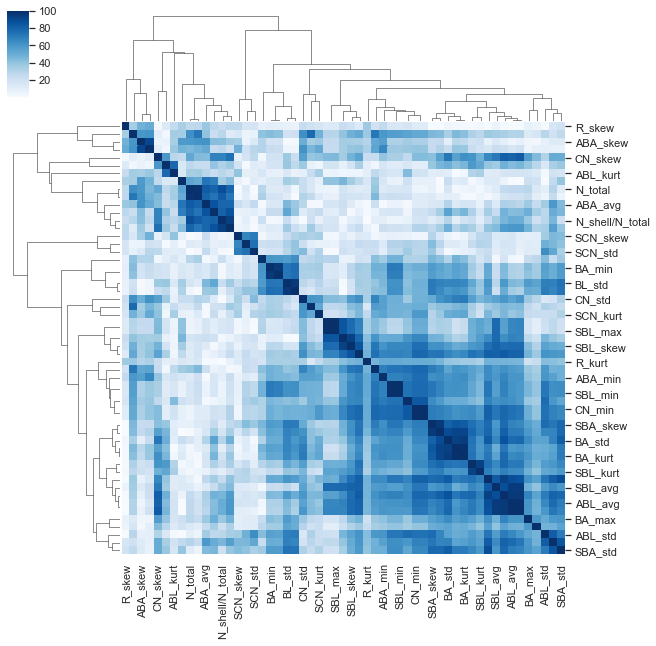

Features with greater than 90% correlation
BL_min           SBL_min     99.933624
CN_min           SCN_min     99.925031
BL_max           SBL_max     99.783323
ABL_avg          BL_avg      99.288467
BA_skew          BA_kurt     99.055654
N_total          R_avg       98.769325
SBA_skew         SBA_kurt    96.476018
BL_std           SBL_std     96.056495
CN_avg           BL_avg      96.038264
                 ABL_avg     96.008927
BA_min           SBA_min     95.941766
ABL_avg          SBL_avg     95.506526
BL_avg           SBL_avg     95.205191
BA_std           BA_kurt     95.125089
N_shell/N_total  R_min       93.891570
BL_skew          SBL_skew    93.662889
CN_avg           SCN_avg     93.166406
BL_kurt          SBL_kurt    93.117268
BA_std           BA_skew     93.058803
BA_skew          SBA_kurt    92.188743
BA_kurt          SBA_kurt    92.022045
ABA_skew         ABA_kurt    91.261476
dtype: float64


In [5]:
sns.set()
correlated = X_features.corr(method='spearman').abs().mul(100).astype(float)
plt.figure(figsize=(5,5))
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=50, as_cmap=True)
cg = sns.clustermap(data = correlated, cmap='Blues', metric='correlation', fmt='1g') # removed annot =True
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
correlated.to_csv("correlations.csv")
s = correlated.unstack()
so = s.sort_values(kind="quicksort")

# correlated
cut_off_correlation = 90.0

sol = (correlated.where(np.triu(np.ones(correlated.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

i = 0
while sol[i] > cut_off_correlation:
    i+=1

print ("Features with greater than 90% correlation")
print (sol[0:i])


We will now remove the features with over 90% correlation.This is done at the beginning of each of the Machine learning workflows.

In [6]:
X_feats = X_features.drop([
    # N_total and R_avg kept as it improves results
    'R_min', # for correlation with N_shell/N_total
    'SCN_min', # for correlation with CN_min
    'SCN_avg', 'ABL_avg', 'BL_avg', # for correlation with CN_avg
    'SBL_min', 'SBL_max', 'SBL_avg', 'SBL_std', 'SBL_skew', 'SBL_kurt', # for correlation with BL
    'ABA_kurt', # For correlation with ABA_skew
    'BA_kurt', # For correlation with BA_std and BA_skew
    'SBA_min', # For correlation with BA_min
    'BA_skew', # for correlation with SBA_kurt
    'SBA_skew', 'SBA_kurt' # For correlation with BA_skew, BA_kurt etc
], axis=1)

X_feats.describe()



# for key in X_feats.keys():
#     plt.scatter(X_features[key], y_label)
#     plt.title(target_label+" against "+key)
#     plt.xlabel(key)
#     plt.ylabel(target_label)
#     plt.savefig("images/label_relations/"+target_label.replace("/","")+"_against"+key.replace("/","")+".png", dpi=300)
#     plt.show()
    
# X_feats.describe()

,N_total,N_shell/N_total,R_max,R_avg,R_std,R_skew,R_kurt,CN_min,CN_avg,CN_std,...,ABA_avg,ABA_std,ABA_skew,BA_min,BA_max,BA_avg,BA_std,SBA_max,SBA_avg,SBA_std
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,630.658451,0.493737,16.178408,12.379082,1.425252,0.249665,-0.076445,4.140845,9.289648,2.027581,...,94.453633,4.546140,-1.489444,46.201426,179.718642,95.883292,34.310193,179.421020,92.500173,33.690448
std,230.863656,0.062088,3.192038,1.719876,0.768881,0.470275,1.290653,1.384373,0.812617,0.204524,...,0.642780,0.703678,0.324080,2.348440,0.270844,0.456833,0.685949,0.476239,0.595776,0.571362
min,236.000000,0.388330,9.665202,8.592114,0.485009,-0.771003,-1.424023,1.000000,7.191851,1.549891,...,91.809172,2.960429,-2.614211,38.696325,178.432356,93.780515,33.084558,177.200898,90.973333,32.488791
25%,438.750000,0.445095,14.066641,11.147761,0.860560,-0.047503,-0.698671,3.000000,8.596462,1.874227,...,94.062653,4.052686,-1.685696,45.079956,179.657873,95.549346,33.517871,179.259944,92.120192,33.250572
50%,598.000000,0.487849,16.144654,12.359336,1.157117,0.216507,-0.308612,4.000000,9.498588,2.011459,...,94.548696,4.539342,-1.483863,46.980238,179.809065,95.977161,34.610787,179.552941,92.515976,33.664868
75%,819.750000,0.535529,18.127391,13.753966,1.849234,0.501196,0.126800,5.000000,10.014101,2.195830,...,94.955922,5.002913,-1.288867,47.906385,179.896390,96.254189,34.903179,179.728773,92.886249,34.140185
max,1214.000000,0.736842,25.874050,16.031342,3.929259,2.532002,13.654322,6.000000,10.591549,2.442414,...,95.696520,6.332264,-0.323653,49.333752,179.994264,96.637302,35.238230,179.988261,94.560597,35.035268


### Feature Scaling

This is repeated at the beginning of each of the Decision tree workflows

In [7]:
X_scaled = RobustScaler().fit_transform(X_feats)
y_label = np.array(y_label).reshape(-1,1)

# T-SNE Visualisation

Visualization of data relationships compressed to two dimensions using the manifold learning method of t-distributed stochastic neighbour embedding.

In [8]:
from sklearn.manifold import TSNE

n_components = 2
perplexity = 20
random_state = 42

model_TSNE = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)

start = time.time()
X_TSNE = model_TSNE.fit_transform(X_scaled)
stop = time.time()

print(f"Training time: {stop - start}s")

Training time: 1.2127408981323242s


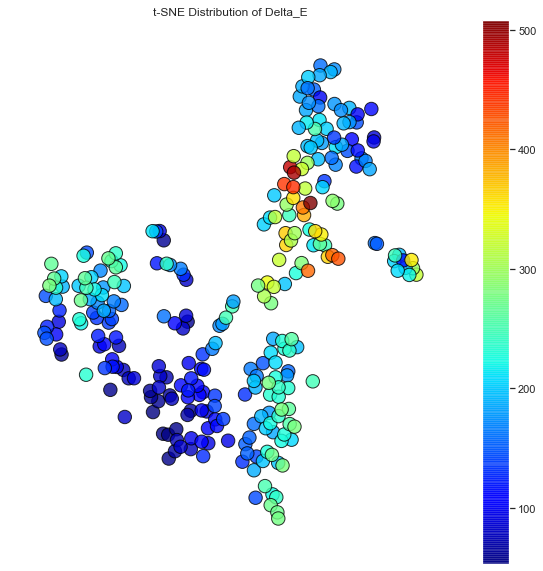

In [9]:
plot_embedding(X_TSNE,
               X_df['Delta_E'].values,
               X_df['Delta_E'],
               discrete=False, title="t-SNE Distribution of Delta_E")
plt.savefig("t-SNE/t-SNE_Distribution_of_Delta_EN.png", dpi=300)
plt.show()

# for key in X_feats.keys():
#     plot_embedding(X_TSNE,
#                X_df[key].values,
#                X_df[key],
#                discrete=False, title="t-SNE Distribution of "+key)
    
#     plt.savefig("t-SNE/t-SNE_distribution_of_"+key.replace("/","")+".png", dpi=300)
#     plt.show()